In [32]:
import pandas as pd
import geopandas as gpd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from shapely.geometry import Point
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data and reshape by destination for each category
def load_and_pivot(file, prefix):
    df = pd.read_csv(file)
    df_pivot = df.pivot_table(index='isochrone_file', columns='time', values='point_count', aggfunc='mean').add_prefix(prefix)
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.fillna(0)
    return df_pivot

In [3]:
transit_education = load_and_pivot("transit_education.csv", "t_educ_")
transit_health = load_and_pivot("transit_health_and_social_action.csv", "t_health_")
transit_services = load_and_pivot("transit_services_for_individuals.csv", "t_services_")
transit_shops = load_and_pivot("transit_shops.csv", "t_shops_")
transit_sports = load_and_pivot("transit_sports_leisure_and_recreation.csv", "t_sports_")
transit_tourism = load_and_pivot("transit_tourism.csv", "t_tourism_")
transit_transport = load_and_pivot("transit_transport_and_travel.csv", "t_transp_")

In [4]:
# Merging all transit data on 'isochrone_file'
transit_merged = transit_education
for df in [transit_health, transit_services, transit_shops, transit_sports, transit_tourism, transit_transport]:
    transit_merged = transit_merged.merge(df, on='isochrone_file', how='outer')

In [5]:
transit_merged.shape

(5296, 43)

In [14]:
def perform_pca(data):
    features = data.columns[1:]  # exclude 'isochrone_file' and  coordinates  (x and y) columns
    x = data[features]
    x = x.fillna(0)
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_
    print(f'Explained variance ratio: {explained_variance}')
    return pca, principal_components

In [7]:
transit_pca, transit_pcs = perform_pca(transit_merged)

Explained variance ratio: [0.78512825 0.08555694]


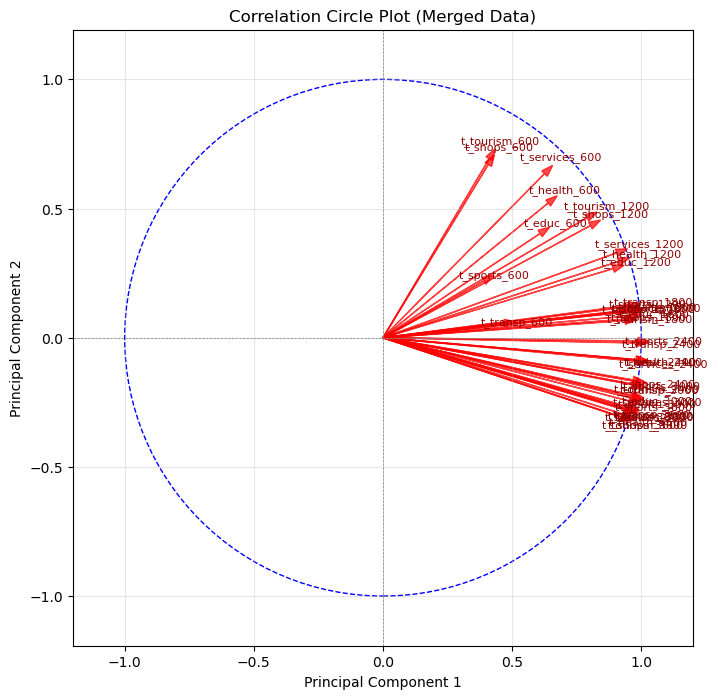

In [16]:
# Normalize the PCA loadings to ensure they fit within the unit circle
loadings = transit_pca.components_.T * np.sqrt(transit_pca.explained_variance_)
features = transit_merged.columns[1:]

plt.figure(figsize=(8, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Unit circle
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Variable contributions (scaled to the circle)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              color='red', alpha=0.7, head_width=0.03)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, 
             fontsize=8, color='darkred', ha='center', va='center')

# Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Correlation Circle Plot (Merged Data)")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.grid(alpha=0.3)
plt.show()


In [17]:
# Prepare the data for spatial visualization by adding back coordinates
pca_results = pd.DataFrame(transit_pcs, columns = [f'PC{i+1}' for i in range(transit_pcs.shape[1])])
pca_results['y'] = transit_merged['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
pca_results['x'] = transit_merged['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters
geometry = [Point(xy) for xy in zip(pca_results['x'], pca_results['y'])]
pca_results['geometry']= geometry

In [18]:
gdf = gpd.GeoDataFrame(pca_results, geometry=geometry)
gdf.set_crs("EPSG:3035", inplace=True)

PC1       PC2        y        x                 geometry
0    -4.339044  0.440027  2772600  3736600  POINT (3736600 2772600)
1    -4.346270  0.421819  2772600  3736800  POINT (3736800 2772600)
2    -4.013306  0.836800  2772600  3737000  POINT (3737000 2772600)
3    -3.853586  1.116784  2772600  3737200  POINT (3737200 2772600)
4    -3.897614  1.017164  2772600  3737400  POINT (3737400 2772600)
...        ...       ...      ...      ...                      ...
5291 -4.345862  0.456180  2796000  3702200  POINT (3702200 2796000)
5292 -4.392179  0.382440  2796000  3709000  POINT (3709000 2796000)
5293 -4.416335  0.394324  2796000  3709200  POINT (3709200 2796000)
5294 -4.419395  0.392976  2796000  3709600  POINT (3709600 2796000)
5295 -4.370179  0.385370  2796200  3702600  POINT (3702600 2796200)

[5296 rows x 5 columns]

In [19]:
gdf.explore()

In [20]:
# Export to a shapefile
gdf.to_file("C:/Users/kbons/accessibility/project_report/metrics/transit_metrics3.shp", driver="ESRI Shapefile")

print("Shapefile has been created successfully.")

Shapefile has been created successfully.


In [21]:
transit_merged.to_csv("C:/Users/kbons/accessibility/project_report/transit_merged2.csv", index = False, sep =',')

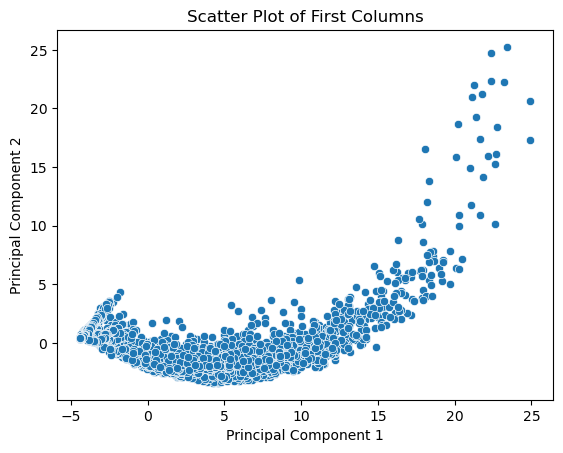

In [23]:
# Plot using seaborn
sns.scatterplot(data=gdf, x=gdf.iloc[:,0], y=gdf.iloc[:,1])

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Principal Components')

# Show the plot
plt.show()


C:\Users\kbons\AppData\Local\Temp\ipykernel_6584\2333853985.py:11: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroids[:, 0], centroids[:, 1], edgecolors='red', marker='x', s=200, label='Centroids')


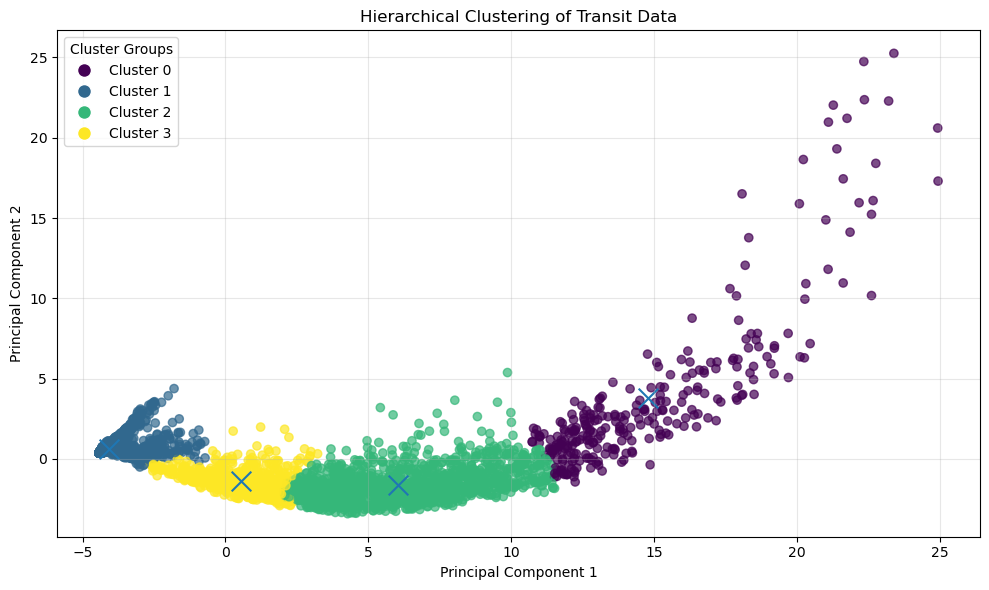

In [52]:
# Perform Hierarchical Clustering
clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(transit_pcs)

# Calculate centroids for each cluster
centroids = np.array([transit_pcs[labels == i].mean(axis=0) for i in range(4)])

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(transit_pcs[:, 0], transit_pcs[:, 1], c=labels, cmap='viridis', alpha=0.7, label="Data Points")
plt.scatter(centroids[:, 0], centroids[:, 1], edgecolors='red', marker='x', s=200, label='Centroids')

# Optionally annotate points (uncomment if labels are needed)
# point_labels = transit_merged['isochrone_file'].values
# for i, txt in enumerate(point_labels):
#     plt.annotate(txt, (transit_pcs[i, 0], transit_pcs[i, 1]), fontsize=8)

# Title and formatting
plt.title("Hierarchical Clustering of Transit Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Create a custom legend for the clusters
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(i)),
                          markersize=10, label=f'Cluster {i}') for i in range(4)]
plt.legend(handles=legend_elements, title="Cluster Groups")

# Show the plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
cluster_results = pd.DataFrame({
    'PC1': transit_pcs[:, 0],
    'PC2': transit_pcs[:, 1],
    'Cluster': labels
})

cluster_results['y'] = transit_merged['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
cluster_results['x'] = transit_merged['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters
cluster_results['geometry']= geometry


transit_cluster = gpd.GeoDataFrame(cluster_results, geometry=geometry)
transit_cluster.set_crs("EPSG:3035", inplace=True)

PC1       PC2  Cluster        y        x                 geometry
0    -4.339044  0.440027        1  2772600  3736600  POINT (3736600 2772600)
1    -4.346270  0.421819        1  2772600  3736800  POINT (3736800 2772600)
2    -4.013306  0.836800        1  2772600  3737000  POINT (3737000 2772600)
3    -3.853586  1.116784        1  2772600  3737200  POINT (3737200 2772600)
4    -3.897614  1.017164        1  2772600  3737400  POINT (3737400 2772600)
...        ...       ...      ...      ...      ...                      ...
5291 -4.345862  0.456180        1  2796000  3702200  POINT (3702200 2796000)
5292 -4.392179  0.382440        1  2796000  3709000  POINT (3709000 2796000)
5293 -4.416335  0.394324        1  2796000  3709200  POINT (3709200 2796000)
5294 -4.419395  0.392976        1  2796000  3709600  POINT (3709600 2796000)
5295 -4.370179  0.385370        1  2796200  3702600  POINT (3702600 2796200)

[5296 rows x 6 columns]

In [42]:
transit_cluster['Cluster'].unique()

array([1, 3, 2, 0], dtype=int64)

In [56]:
transit_cluster['Cluster'] = transit_cluster['Cluster'].replace({0: "High", 1: "Very Low", 2:"Moderate", 3:"Low"})

In [57]:
transit_cluster.explore(
    column="Cluster",
    cmap= "viridis", 
    popup=["PC1", "PC2", "Cluster"]
)


In [58]:
transit_cluster.to_file("C:/Users/kbons/accessibility/project_report/metrics/transit_metrics4.shp", driver="ESRI Shapefile")